# Proyecto #1
### Yosef Maldonado - 14003689

In [147]:
# libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression as SKLinearRegression

In [148]:
# loading dataset
'''
SalePrice - the property's sale price in dollars. This is the target variable that you're trying to predict.
OverallQual: Overall material and finish quality, rates the overall material and finish of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor
       
1stFlrSF: First Floor square feet
TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
YearBuilt: Original construction date
LotFrontage: Linear feet of street connected to property
'''

dataset = np.load('./data/proyecto_training_data.npy')

In [149]:
# creating dataframe to label columns
column_labels = ['SalePrice', 'OverallQual', '1stFlrSF', 'TotRmsAbvGrd', 'YearBuilt', 'LotFrontage']
df = pd.DataFrame(dataset, columns=column_labels)

In [150]:
# slicing dataset
df_rows = df.shape[0]
split_index = int(df_rows * 0.80)  # check where to split
df_training_set = df.iloc[:split_index] # 80% of the data
df_validation_and_test_set = df.iloc[split_index:] # 20% of the data

# Análisis exploratorio de datos (Training set)

In [151]:
# training (80% of dataset) analysis
# DataFrame.describe(): https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html#pandas.DataFrame.describe
# Transpose (T): https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.transpose.html
df_training_statistics = df_training_set.describe().T 
df_training_statistics['range'] = df_training_statistics['max'] - df_training_statistics['min'] # range
df_training_statistics = df_training_statistics[['mean', 'max', 'min', 'range', 'std']]
df_training_statistics

,mean,max,min,range,std
SalePrice,180590.277397,755000.0,34900.0,720100.0,78815.697902
OverallQual,6.101027,10.0,1.0,9.0,1.378025
1stFlrSF,1156.323630,3228.0,334.0,2894.0,373.780374
TotRmsAbvGrd,6.485445,14.0,2.0,12.0,1.609141
YearBuilt,1971.451199,2010.0,1875.0,135.0,29.951707
LotFrontage,69.946985,313.0,21.0,292.0,23.478161


# Histograma de variable (Training set)

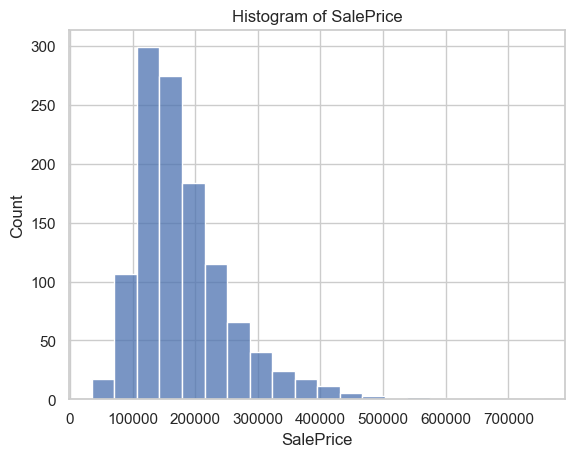

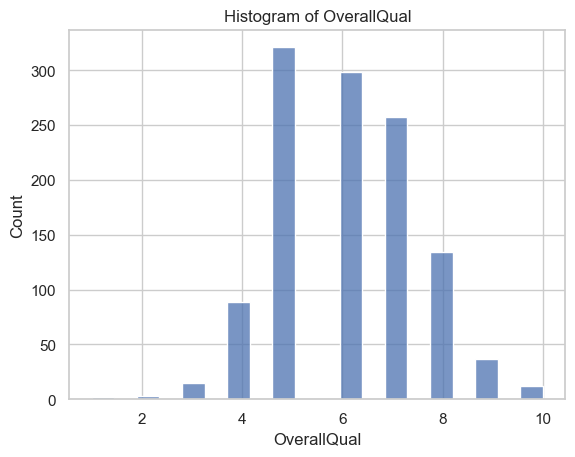

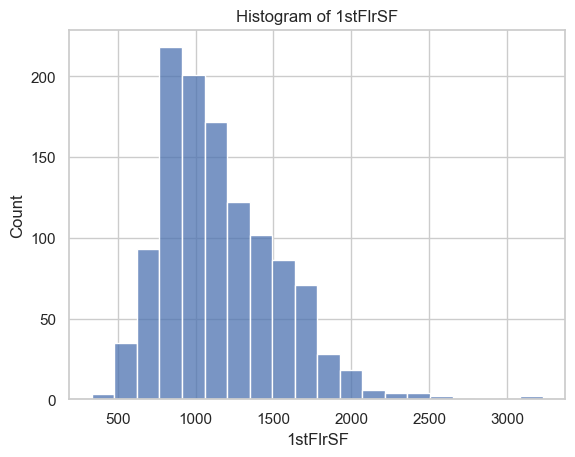

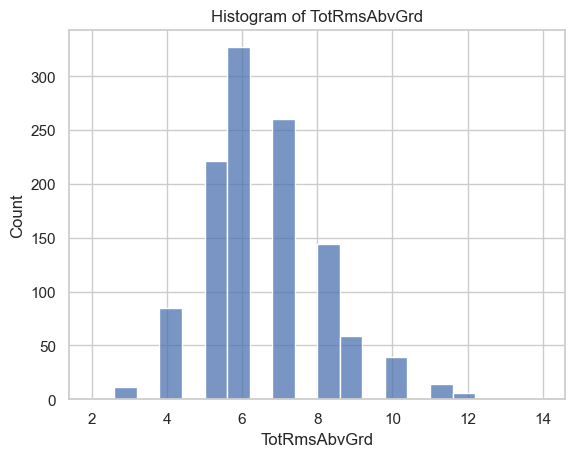

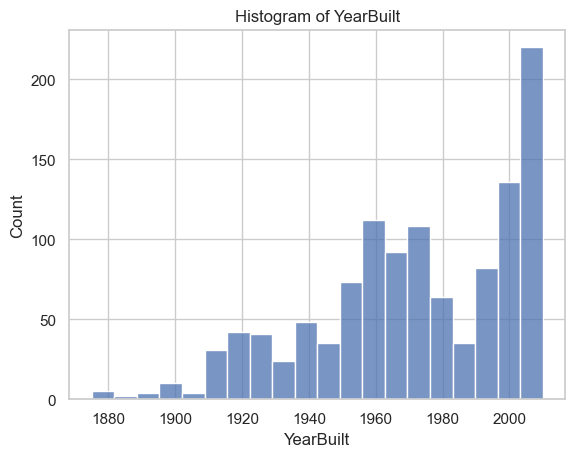

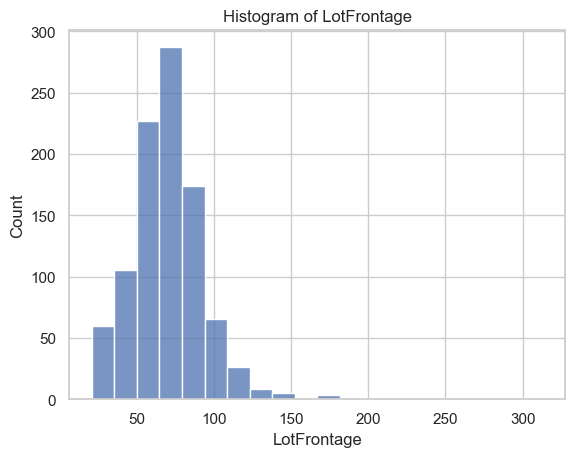

In [152]:
# distplot is deprecated: https://seaborn.pydata.org/generated/seaborn.distplot.html
# using histplot

sns.set(style='whitegrid')

for column in df_training_set.columns:
    sns.histplot(df_training_set[column].dropna(), kde=False, bins=20)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()


# Correlación con variables independientes (Training set)

In [153]:
# SalePrice: "This is the target variable that you're trying to predict" (Dependant variable)

# getting correlations
df_training_correlation_matrix = df_training_set.corr()
df_training_correlation_matrix = df_training_correlation_matrix['SalePrice'].drop('SalePrice')

# convert series to data frame for easier manipulation
df_training_correlation = pd.DataFrame(df_training_correlation_matrix).reset_index()
df_training_correlation.columns = ['Variable', 'Correlation with SalePrice']

# sort by the absolute value of the correlation, descending order (creating temporal column)
df_training_correlation['Absolute Correlation'] = df_training_correlation['Correlation with SalePrice'].abs()
df_training_correlation = df_training_correlation.sort_values(by='Absolute Correlation', ascending=False).drop('Absolute Correlation', axis=1) # removing temporary column

# format the correlation values for better readability
df_training_correlation['Correlation with SalePrice'] = df_training_correlation['Correlation with SalePrice'].apply(lambda x: f'{x:.3f}')

# display the sorted and formatted data frame
df_training_correlation

,Variable,Correlation with SalePrice
0,OverallQual,0.794
1,1stFlrSF,0.616
2,TotRmsAbvGrd,0.565
3,YearBuilt,0.534
4,LotFrontage,0.363


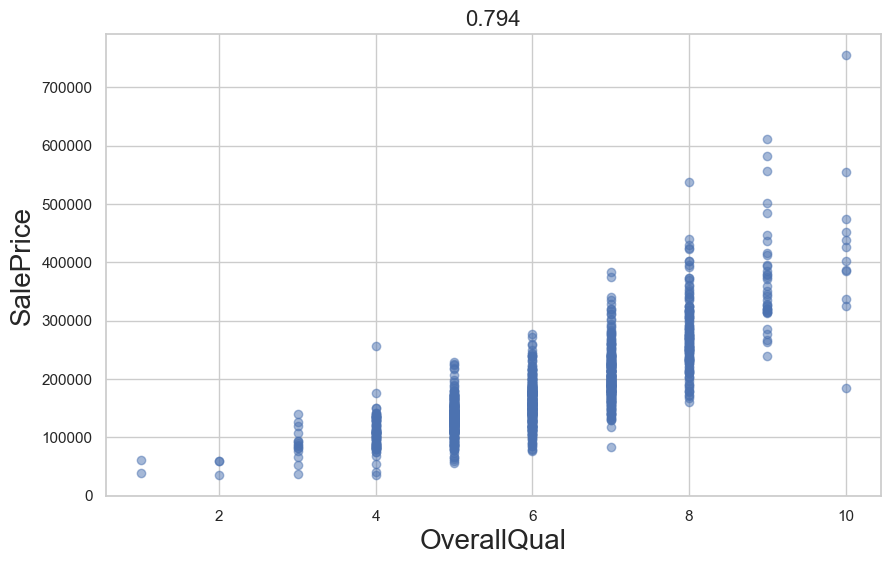

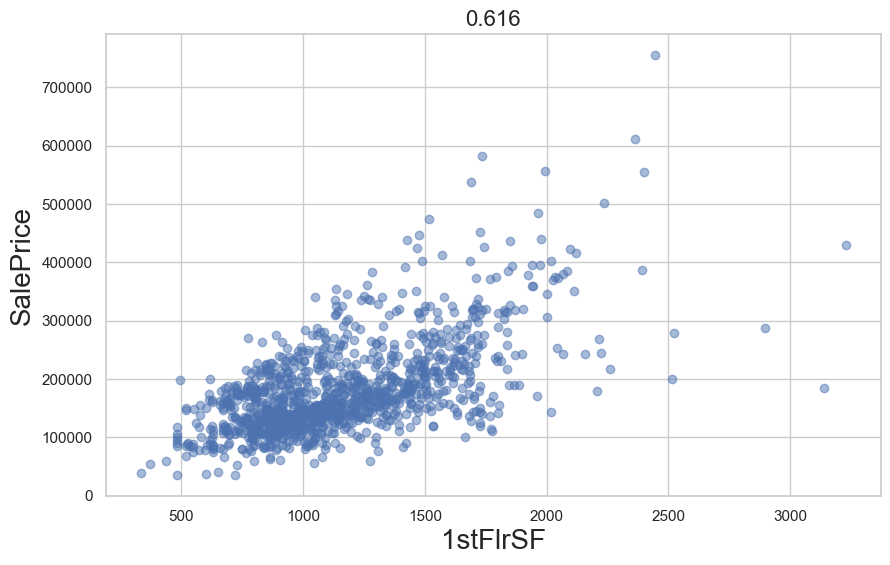

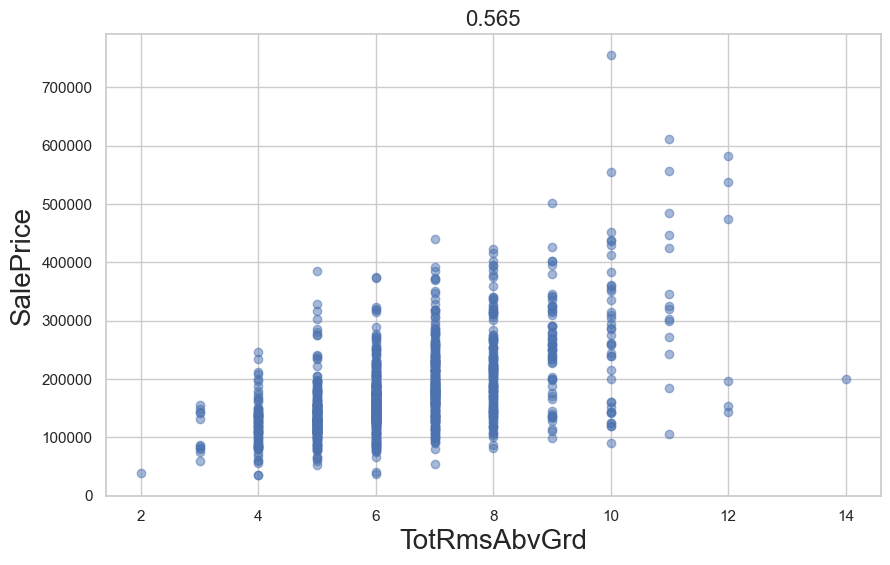

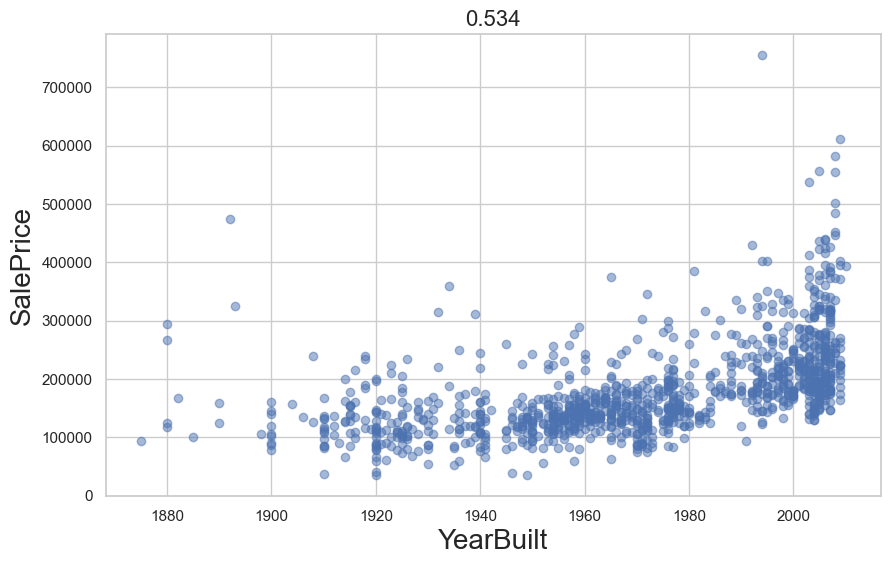

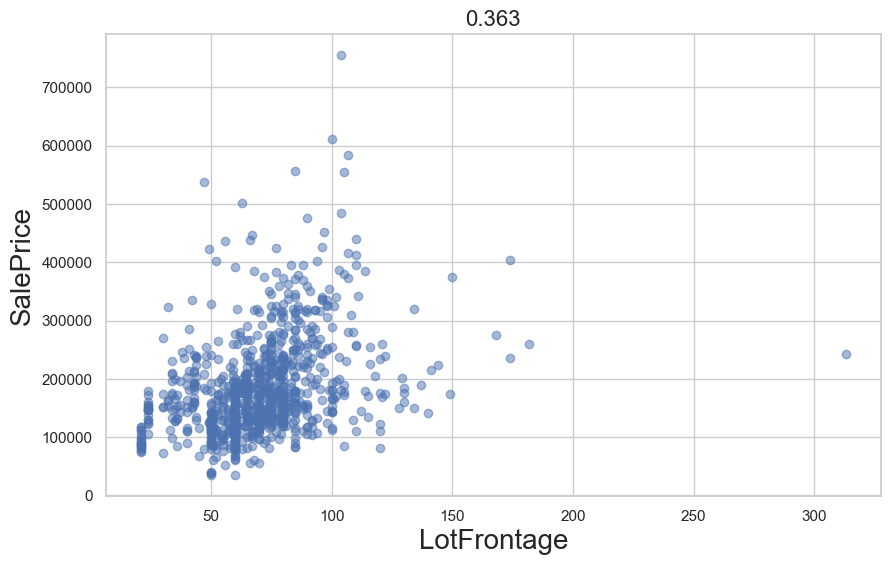

In [154]:
# base on df_training_correlation results
for index, row in df_training_correlation.iterrows():
    variable = row['Variable']
    correlation = row['Correlation with SalePrice']
    plt.figure(figsize=(10, 6))
    plt.scatter(df_training_set[variable], df_training_set['SalePrice'], alpha=0.5)  # plot scatter
    plt.title(correlation, fontsize=16) # correlation value as title
    plt.xlabel(variable, fontsize=20)  # x-axis label
    plt.ylabel('SalePrice', fontsize=20)  # y-axis label
    plt.grid(True)  # adding grid
    plt.show()
    print("\n" * 4)


In [155]:
# variables with more correlation
df_training_correlation.head(2)

,Variable,Correlation with SalePrice
0,OverallQual,0.794
1,1stFlrSF,0.616


# Función para entrenar modelo de regresión lineal

In [156]:
class LinearRegressionStep:
    def __init__(self, vect_x, vect_y, prediction):
        # dynamically assign attributes based on constructor parameters, excluding 'self'
        for name, value in locals().items():
            if name != "self":
                setattr(self, name, value)

In [157]:
class LinearRegression:
    
    def __init__(self):
        self.steps = []
        self.errors = []
        
    def calculate_regression(self, vect_x, vect_y, epochs, print_error_every, learning_rate=0.01):
        # convert inputs to numpy arrays for vectorized operations
        vect_x = np.array(vect_x)
        vect_y = np.array(vect_y)
        # check that input vectors have the same length
        if vect_x.shape[0] != vect_y.shape[0]:
            raise ValueError('Input vectors vect_x and vect_y must have the same length.')
        # prepare observations with a bias term for vector operations
        observations = np.column_stack((vect_x, np.ones(vect_x.shape[0])))
        # initialize β's (betas) coefficients close to zero
        beta = np.random.rand(2).reshape(2, 1) * 0.01
        # clear previous values
        self.errors.clear()
        self.steps.clear()
        # loop for gradient descent
        for epoch in range(epochs):
            # calculate predictions
            prediction = np.dot(observations, beta)
            # calculate error
            error = (1 / (2 * len(vect_y))) * np.sum((vect_y.reshape(-1, 1) - prediction) ** 2)
            # update error directly in self.errors
            self.errors.append(error) 
            # calculate gradient of the error
            gradient_errors = (1 / len(vect_y)) * np.dot(observations.T, (prediction - vect_y.reshape(-1, 1)))
            # update beta coefficients.
            beta_start = beta
            beta -= learning_rate * gradient_errors
            # optionally print the error at specified intervals
            if print_error_every and (epoch + 1) % print_error_every == 0:
                print(f'epoch {epoch + 1}, error: {error}')
            # update step directly in self.steps
            self.steps.append(LinearRegressionStep(vect_x, vect_y, prediction))
        return self.steps, self.errors
    
    def plotErrors(self, errors=None, show_values=False):
        if errors is None:
            errors = self.errors
        if not errors:
            raise ValueError('No errors to plot. The array is empty.')
        # plotting
        plt.figure(figsize=(10, 6))
        iterations = range(1, len(errors) + 1)
        plt.plot(iterations, errors, marker='o', linestyle='-', markersize=5)
        if show_values:
            for i, error in enumerate(errors, start=1):
                plt.text(i, error, f'{error:.2f}', ha='center', va='bottom')
        plt.title('chronological error', fontsize=16)
        plt.xlabel('iteration', fontsize=20)
        plt.ylabel('error', fontsize=20)
        plt.grid(True)
        plt.show()
        
    def plotSteps(self, steps=None, n=1):
        if steps is None:
            steps = self.steps
        if not steps:
            raise ValueError('No steps to plot. The array is empty.')
        # plotting
        plt.figure(figsize=(10, 6))
        vect_x = steps[0].vect_x
        vect_y = steps[0].vect_y
        plt.scatter(vect_x, vect_y, color='blue', label='training data')
        for i, step in enumerate(steps):
            if (i + 1) % n == 0:
                plt.plot(vect_x, step.prediction, label=f'Iteration {i + 1}')
        plt.title('model evolution', fontsize=16)
        plt.xlabel('x', fontsize=20)
        plt.ylabel('y', fontsize=20)
        plt.legend()
        plt.grid(True)
        plt.show()    
        

epoch 5, error: 7.992684783511976
epoch 10, error: 2.2856720230769922
epoch 15, error: 0.6651875696798977
epoch 20, error: 0.20486282303424252
epoch 25, error: 0.07390906602449708
epoch 30, error: 0.036467407691360365
epoch 35, error: 0.02557803022292296
epoch 40, error: 0.02223113645307525
epoch 45, error: 0.02102981996145108
epoch 50, error: 0.020441840782390277
epoch 55, error: 0.020032129181240938
epoch 60, error: 0.019677100460850843
epoch 65, error: 0.0193416009038318
epoch 70, error: 0.019015583270564986
epoch 75, error: 0.01869612911412776
epoch 80, error: 0.018382344942092933
epoch 85, error: 0.01807391323118724
epoch 90, error: 0.017770681045739752
epoch 95, error: 0.017472543229524653
epoch 100, error: 0.017179409226548478
epoch 105, error: 0.016891193644178057
epoch 110, error: 0.016607813556951505
epoch 115, error: 0.016329187724338366
epoch 120, error: 0.016055236352146212


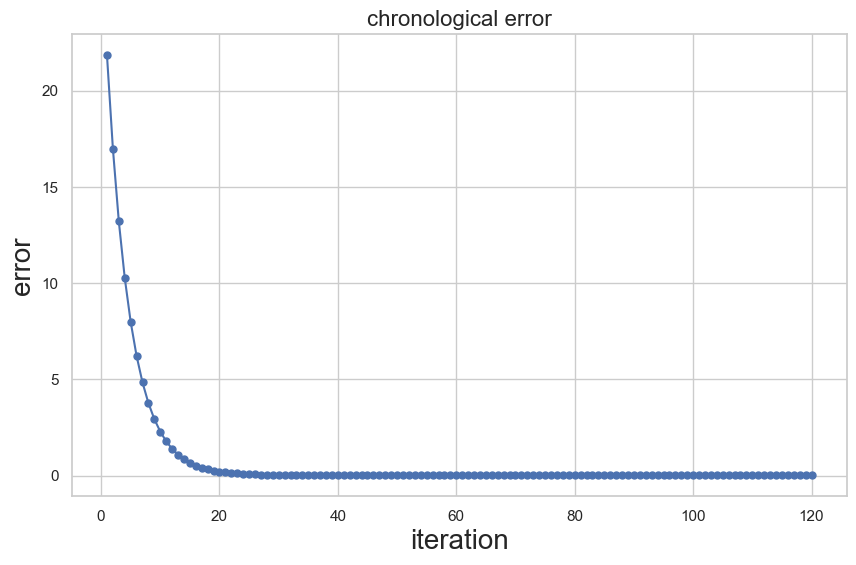

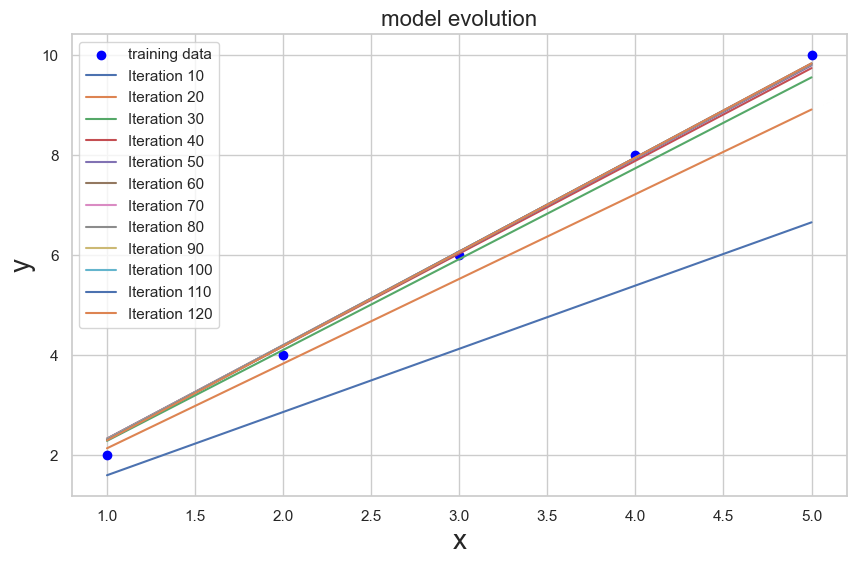

In [158]:
# debug
x = np.array([1, 2, 3, 4, 5])
y = np.array([2, 4, 6, 8, 10])
model = LinearRegression()
steps, errors = model.calculate_regression(vect_x=x, vect_y=y, epochs=120, print_error_every=5, learning_rate=0.01)
model.plotErrors()
model.plotSteps(n=10)


# Entrenamiento con variables independientes

In [159]:
# traning dataset
df_SalesPrice = df_training_set['SalePrice'].values
df_OverallQual = df_training_set['OverallQual'].values
df_1stFlrSF = df_training_set['1stFlrSF'].values

## OverallQuall vs SalesPrice

epoch 5, error: 1693499425.7948148
epoch 10, error: 1394454396.9891138
epoch 15, error: 1391513814.8814025
epoch 20, error: 1390347594.1648831
epoch 25, error: 1389197400.3669872
epoch 30, error: 1388052703.6716626
epoch 35, error: 1386913415.65489
epoch 40, error: 1385779510.3894155
epoch 45, error: 1384650962.4413366
epoch 50, error: 1383527746.4991355
epoch 55, error: 1382409837.370894
epoch 60, error: 1381297209.9837186
epoch 65, error: 1380189839.3831754
epoch 70, error: 1379087700.7327328
epoch 75, error: 1377990769.313203
epoch 80, error: 1376899020.5221882
epoch 85, error: 1375812429.8735275
epoch 90, error: 1374730972.9967504
epoch 95, error: 1373654625.6365275
epoch 100, error: 1372583363.652128
epoch 105, error: 1371517163.0168781
epoch 110, error: 1370455999.817621
epoch 115, error: 1369399850.2541826
epoch 120, error: 1368348690.638835


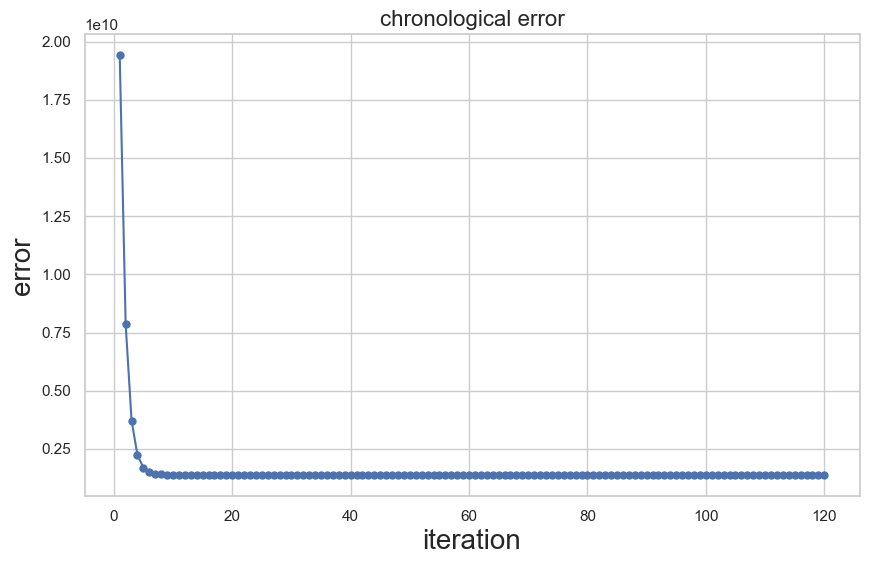

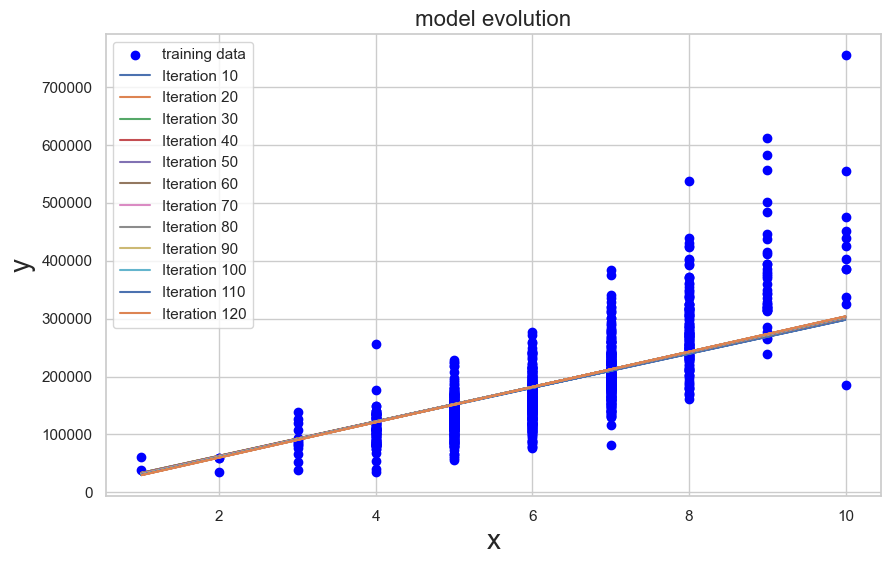

In [160]:
# OverallQuall vs SalesPrice
L_OverallQualSalesPriceModel = LinearRegression()
L_OverallQualSalesPriceModelSteps, L_OverallQualSalesPriceModelErrors = L_OverallQualSalesPriceModel.calculate_regression(vect_x=df_OverallQual, vect_y=df_SalesPrice, epochs=120, print_error_every=5, learning_rate=0.01)
L_OverallQualSalesPriceModel.plotErrors()
L_OverallQualSalesPriceModel.plotSteps(n=10)

## 1stFlrSF vs SalesPrice

epoch 5, error: 2014583193.6553102
epoch 10, error: 1968121147.4447021
epoch 15, error: 1968092965.0985475
epoch 20, error: 1968092906.9667332
epoch 25, error: 1968092865.8693244
epoch 30, error: 1968092824.782272
epoch 35, error: 1968092783.6952643
epoch 40, error: 1968092742.6082954
epoch 45, error: 1968092701.5213656
epoch 50, error: 1968092660.434475
epoch 55, error: 1968092619.3476226
epoch 60, error: 1968092578.260809
epoch 65, error: 1968092537.1740348
epoch 70, error: 1968092496.0872993
epoch 75, error: 1968092455.0006022
epoch 80, error: 1968092413.9139445
epoch 85, error: 1968092372.827325
epoch 90, error: 1968092331.7407446
epoch 95, error: 1968092290.6542032
epoch 100, error: 1968092249.5677004
epoch 105, error: 1968092208.481237
epoch 110, error: 1968092167.394812
epoch 115, error: 1968092126.3084257
epoch 120, error: 1968092085.2220788


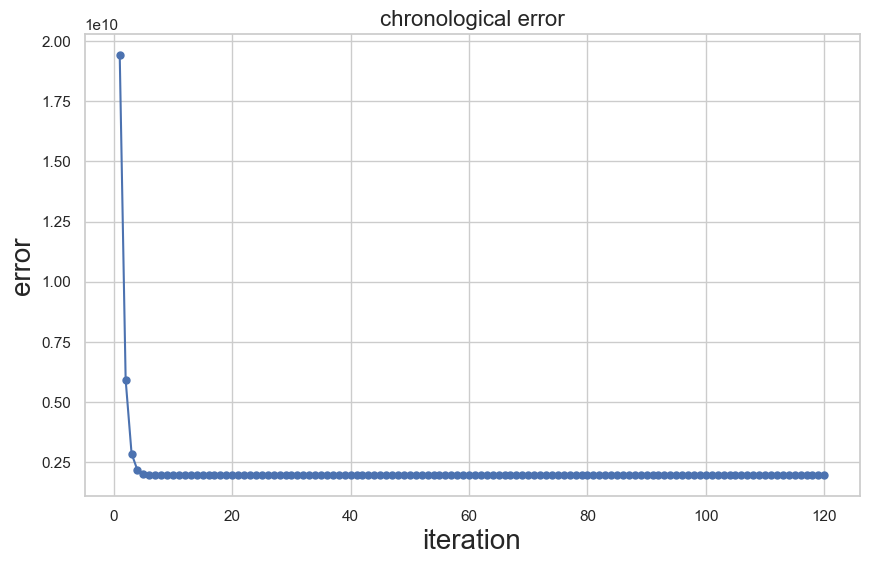

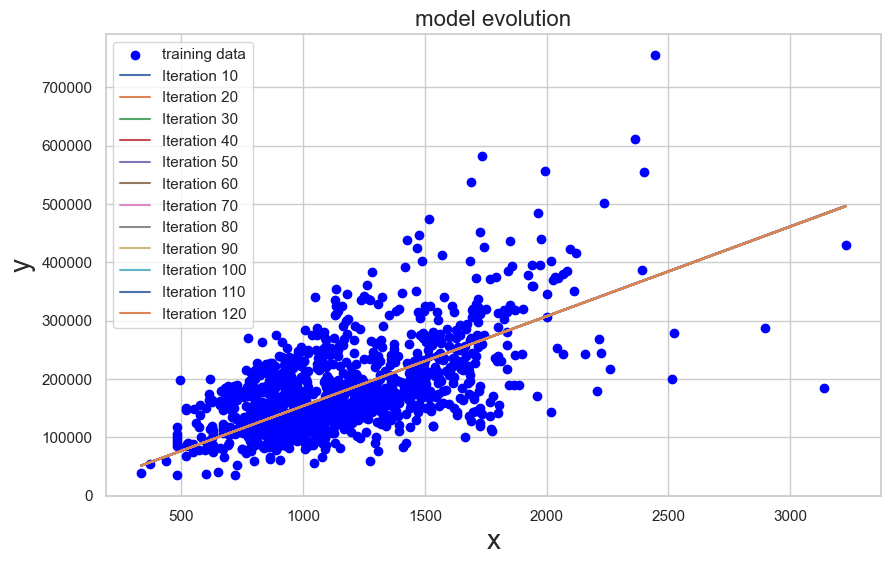

In [161]:
# 1stFlrSF vs SalesPrice
L_1stFlrSFSalesPriceModel = LinearRegression()
L_1stFlrSFSalesPriceModelSteps, L_1stFlrSFSalesPriceModelErrors = L_1stFlrSFSalesPriceModel.calculate_regression(vect_x=df_1stFlrSF, vect_y=df_SalesPrice, epochs=120, print_error_every=5, learning_rate=0.000001)
L_1stFlrSFSalesPriceModel.plotErrors()
L_1stFlrSFSalesPriceModel.plotSteps(n=10)

# sklearn

In [162]:
model = SKLinearRegression()